In [2]:
import numpy as np
import pandas as pd

import unicodedata, re, string
import nltk

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
import os
print(os.listdir("./data/"))

['sampleSubmission.csv', 'test.tsv', 'test.tsv.zip', 'train.tsv', 'train.tsv.zip']


In [3]:
df_train = pd.read_csv("./data/train.tsv", sep="\t")
df_test = pd.read_csv("./data/test.tsv", sep="\t")

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [5]:
df_train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [6]:
df_train['Phrase'][0]

'A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .'

In [7]:
df_train.loc[df_train['SentenceId'] == 1]

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
...,...,...,...,...
58,59,1,much,2
59,60,1,of a story,2
60,61,1,a story,2
61,62,1,story,2


<AxesSubplot:>

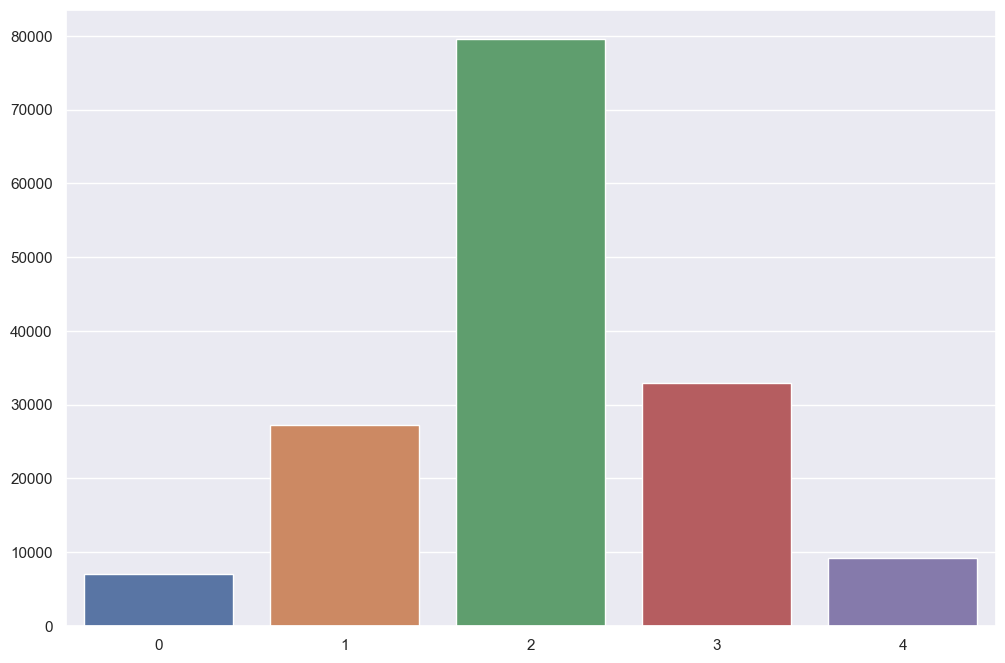

In [11]:
dist = df_train.groupby(["Sentiment"]).size()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=list(dist.keys()), y=list(dist.values))

## 数据预处理

In [12]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
#    words = remove_stopwords(words)
    return words

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fuqilingbuxiu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [15]:
# First step - tokenizing phrases
df_train['Words'] = df_train['Phrase'].apply(nltk.word_tokenize)

# Second step - passing through prep functions
df_train['Words'] = df_train['Words'].apply(normalize) 
df_train['Words'].head()

0    [a, series, of, escapades, demonstrating, the,...
1    [a, series, of, escapades, demonstrating, the,...
2                                          [a, series]
3                                                  [a]
4                                             [series]
Name: Words, dtype: object

In [16]:
# Third step - creating a list of unique words to be used as dictionary for encoding
word_set = set()
for l in df_train['Words']:
    for e in l:
        word_set.add(e)
        
word_to_int = {word: ii for ii, word in enumerate(word_set, 1)}

# Check if they are still the same lenght
print(len(word_set))
print(len(word_to_int))

16209
16209


In [17]:
# Now the dict to tokenize each phrase
df_train['Tokens'] = df_train['Words'].apply(lambda l: [word_to_int[word] for word in l])
df_train['Tokens'].head()

0    [1310, 3229, 2978, 13478, 11655, 6614, 14704, ...
1    [1310, 3229, 2978, 13478, 11655, 6614, 14704, ...
2                                         [1310, 3229]
3                                               [1310]
4                                               [3229]
Name: Tokens, dtype: object

In [18]:
# Step four - get the len of longest phrase
max_len = df_train['Tokens'].str.len().max()
print(max_len)

48


In [19]:
# Pad each phrase representation with zeroes, starting from the beginning of sequence
# Will use a combined list of phrases as np array for further work. This is expected format for the Pytorch utils to be used later

all_tokens = np.array([t for t in df_train['Tokens']])
encoded_labels = np.array([l for l in df_train['Sentiment']])

# Create blank rows
features = np.zeros((len(all_tokens), max_len), dtype=int)
# for each phrase, add zeros at the end 
for i, row in enumerate(all_tokens):
    features[i, :len(row)] = row

#print first 3 values of the feature matrix 
print(features[:3])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (156060,) + inhomogeneous part.